In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import pickle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from util import preprocess
from util import generate_batch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']
from util import cm_plot

In [ ]:
total_cms = []
acc_best_model_list=[4, 4, 5, 5, 5, 4, 4, 5, 4, 3]
loss_best_model_list=[5, 5, 5, 5, 5, 4, 5, 5, 4, 5]
for i in range(0,10):

    # f3 = open('data/split_10fold_No%d_aug_to_15000_down_sample_False_instance0-9/test_data'%i, 'rb')
    f3 = open('data/split_10fold_No%d_aug_to_2500_down_sample_True_instance0-9/test_data'%i, 'rb')
    X_sequence_test, X_feature_test, Y_test = pickle.load(f3)
    f3.close()

    from keras.preprocessing.sequence import pad_sequences
    X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)

    from util import preprocess
    X_sequence_test_trimed = preprocess(X_sequence_test_paded)
    X_feature_test = np.array(X_feature_test)
    Y_test = np.array(Y_test)-1
    Y_test_one_hot = keras.utils.to_categorical(Y_test, num_classes=11)

    models = []
    for j in range(0,10):
        lodaed_model = keras.models.load_model('models/10fold%d/bagging0/rnn_with_feature%d/model_%d'%(i,j, acc_best_model_list[i]))
        models.append(lodaed_model)

    test_gen = generate_batch(X_sequence=X_sequence_test_trimed, X_feature=X_feature_test, Y=Y_test, batch_size=128)      
    y_label = Y_test

    y_predict = np.array([])
    for x_sequence, x_image, x_feature, y in test_gen:
        results = []
        for model in models:
            results.append(model.predict({'sequence':x_sequence, 
                                            # 'image':x_image,
                                            'feature':x_feature}))
        average_result = np.sum(results, axis=0)
        y_predict = np.concatenate([y_predict, np.argmax(average_result, axis=-1)])
    y_label = y_label.astype(np.int32) 
    y_predict = y_predict.astype(np.int32) 
    cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
    total_cms.append(cm)

    print('cm_no.%d'%i)
    plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                        cmap=plt.cm.Blues)
    plotting.show()

Confusion matrix, without normalization
[[8.41435185e-01 2.31481481e-03 8.10185185e-03 9.25925926e-02
  1.15740741e-03 0.00000000e+00 2.31481481e-03 0.00000000e+00
  0.00000000e+00 4.28240741e-02 1.15740741e-03]
 [1.33333333e-03 8.48000000e-01 1.18666667e-01 0.00000000e+00
  6.66666667e-03 1.33333333e-03 8.00000000e-03 0.00000000e+00
  5.33333333e-03 0.00000000e+00 0.00000000e+00]
 [2.00000000e-02 1.40000000e-01 8.10000000e-01 2.00000000e-02
  0.00000000e+00 0.00000000e+00 1.00000000e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.76470588e-01 0.00000000e+00 0.00000000e+00 8.23529412e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.06382979e-03 2.65957447e-04 5.31914894e-04 0.00000000e+00
  7.71276596e-01 5.26595745e-02 1.70478723e-01 2.65957447e-04
  5.31914894e-04 7.97872340e-04 1.59574468e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.66666667e-02 9.75555556e-01 5.5555

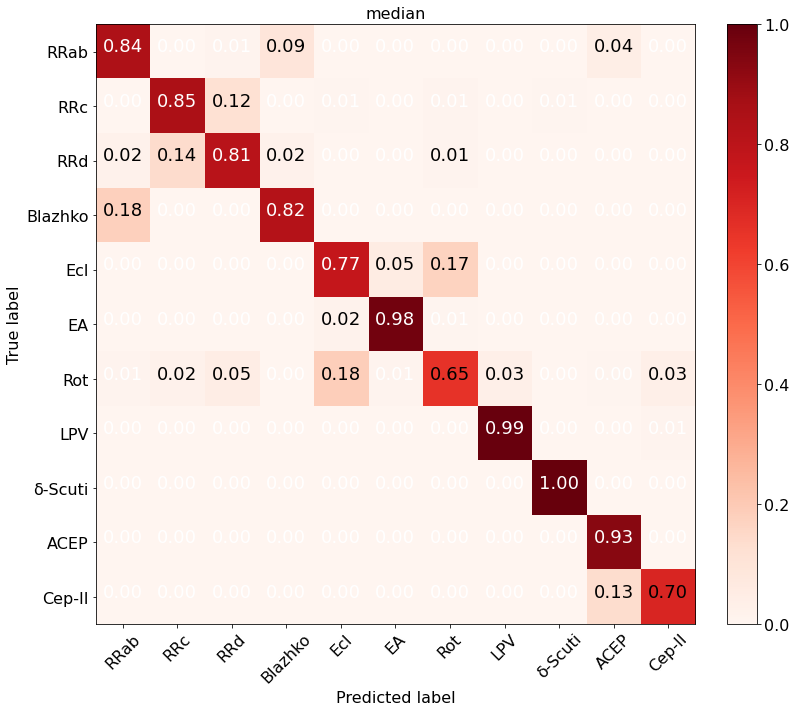

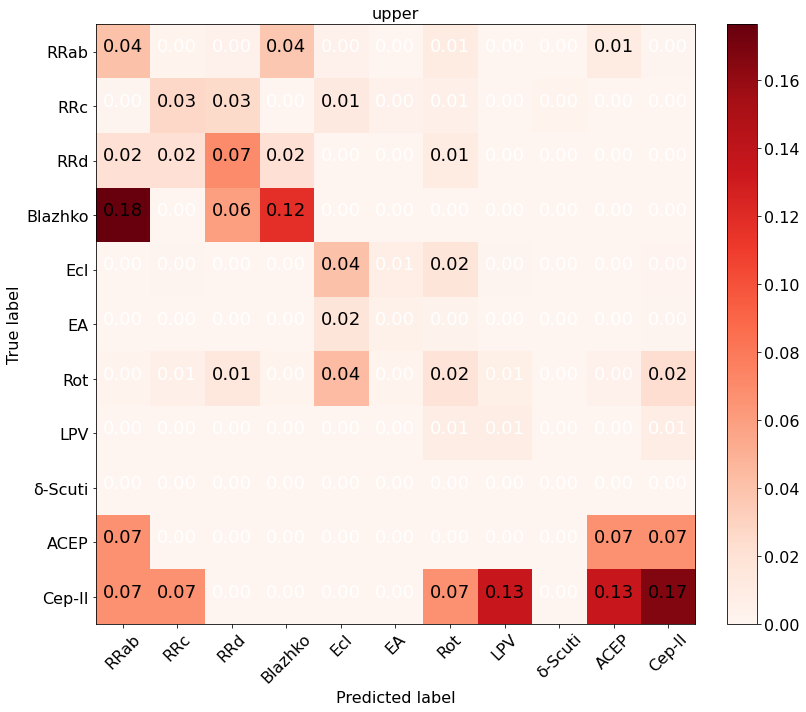

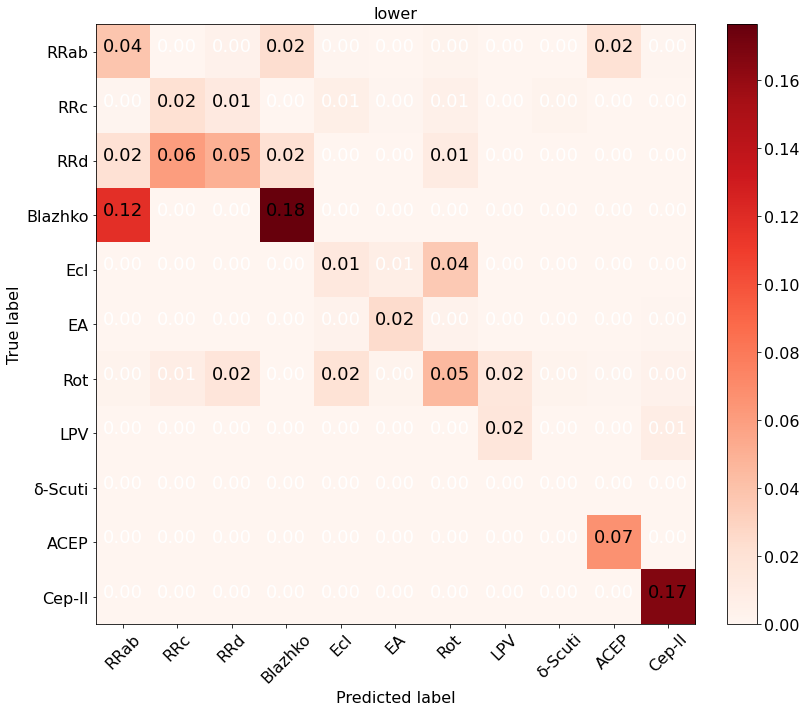

In [5]:
f = open('total_cms_cross_bagging_best_acc','rb')
total_cms = pickle.load(f)
f.close()
# total_cms = np.array(total_cms)
mid_cm = np.median(total_cms, axis=0)
sorted_total_cms = np.sort(total_cms, axis=0)
uppers = np.zeros(mid_cm.shape)
lowers = np.zeros(mid_cm.shape)
for i in range(0,11):
    for j in range(0,11):
        uppers[i][j] = sorted_total_cms[-2][i][j] - mid_cm[i][j]
        lowers[i][j] = mid_cm[i][j] - sorted_total_cms[1][i][j]

from util import plot_confusion_matrix
fig = plot_confusion_matrix(mid_cm, classes, normalize=False, title='median')
fig.show()
fig = plot_confusion_matrix(uppers, classes, normalize=False, title='upper' )
fig.show()
fig = plot_confusion_matrix(lowers, classes, normalize=False, title='lower' )
fig.show()
# f = open('total_cms_cross_bagging_best_acc','wb')
# pickle.dump(total_cms, f)
# f.close()

[[8.41435185e-01 2.31481481e-03 8.10185185e-03 9.25925926e-02
  1.15740741e-03 0.00000000e+00 2.31481481e-03 0.00000000e+00
  0.00000000e+00 4.28240741e-02 1.15740741e-03]
 [1.33333333e-03 8.48000000e-01 1.18666667e-01 0.00000000e+00
  6.66666667e-03 1.33333333e-03 8.00000000e-03 0.00000000e+00
  5.33333333e-03 0.00000000e+00 0.00000000e+00]
 [2.00000000e-02 1.40000000e-01 8.10000000e-01 2.00000000e-02
  0.00000000e+00 0.00000000e+00 1.00000000e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.76470588e-01 0.00000000e+00 0.00000000e+00 8.23529412e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.06382979e-03 2.65957447e-04 5.31914894e-04 0.00000000e+00
  7.71276596e-01 5.26595745e-02 1.70478723e-01 2.65957447e-04
  5.31914894e-04 7.97872340e-04 1.59574468e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.66666667e-02 9.75555556e-01 5.55555556e-03 0.00000000e+00
  0.00000000e+00

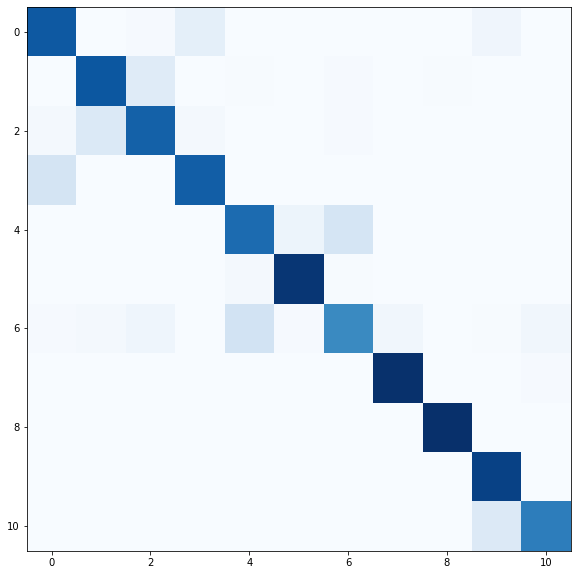

In [26]:
print(mid_cm)
print(uppers.dtype)
print(lowers.dtype)
fig, ax = plt.subplots(figsize=(12, 10))
plt.imshow(mid_cm, interpolation='nearest', cmap=plt.cm.Blues)

Normalized confusion matrix
[[ 84.   0.   1.   9.   0.   0.   0.   0.   0.   4.   0.]
 [  0.  85.  12.   0.   1.   0.   1.   0.   1.   0.   0.]
 [  2.  14.  81.   2.   0.   0.   1.   0.   0.   0.   0.]
 [ 18.   0.   0.  82.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  77.   5.  17.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   2.  98.   1.   0.   0.   0.   0.]
 [  1.   2.   5.   0.  18.   1.  65.   3.   0.   0.   3.]
 [  0.   0.   0.   0.   0.   0.   0.  99.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  93.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  13.  70.]]


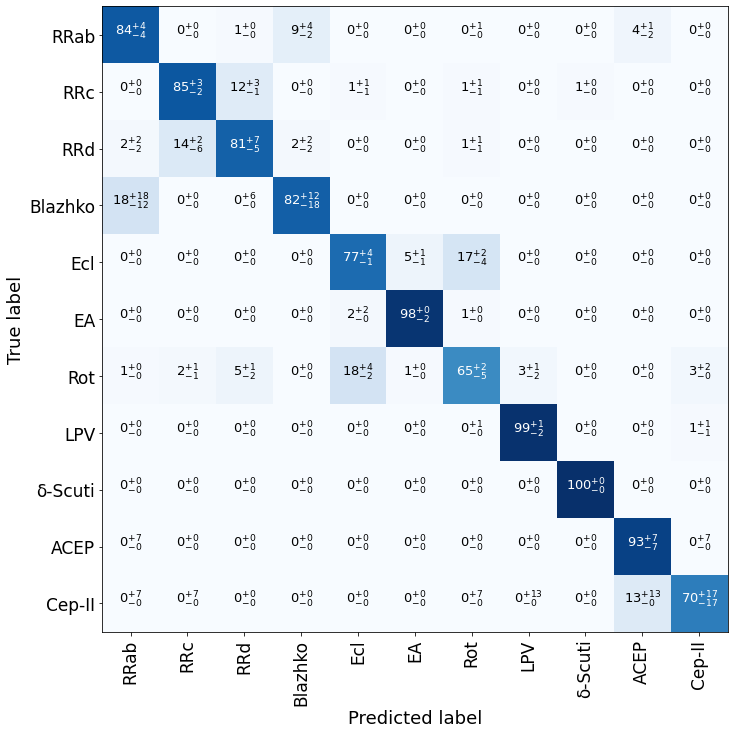

In [6]:

import itertools
from statistics import median
def plot_confusion_matrix(cm, cm_2,cm_3,classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round(cm * 100)
        print("Normalized confusion matrix")
        cm_2 = np.round(cm_2* 100)
        cm_3 = np.round(cm_3 * 100)
        # cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100)
        # print("Normalized confusion matrix")
        # cm_2 = np.round((cm_2.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100)
        # cm_3 = np.round((cm_3.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100)

    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=17)
    plt.yticks(tick_marks, classes, fontsize=17)

    # fmt = '.2f' if normalize else 'd'
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d$_{-%d}^{+%d}$"% (cm[i, j],cm_2[i,j],cm_3[i,j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=13)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.savefig(plot_name, bbox_inches='tight')
    # plt.close()

plot_confusion_matrix(mid_cm, lowers,uppers, classes, 'name',
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)